In [232]:
import pandas as pd
import numpy as np
from tensorflow.keras import layers
import tensorflow as tf 
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OneHotEncoder
import tensorflow.keras as keras
from tensorflow.keras.layers import Concatenate,concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D,MaxPooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D as Conv1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.constraints import unit_norm

from sklearn.metrics import roc_curve, auc, confusion_matrix,accuracy_score,precision_score
import seaborn as sns
import matplotlib.pyplot as plt

In [200]:
review_df = pd.read_pickle('/content/food_review_places1.pickle')

In [201]:
review_df['rating'].value_counts()

5.0    34487
4.0    19041
3.0     8118
2.0     5010
1.0     3539
Name: rating, dtype: int64

In [202]:
review_df

,gPlusPlaceId,rating,reviewerName,reviewText,categories,unixReviewTime,reviewTime,gPlusUserId,name,price,address,hours,phone,closed,gps,lat,long,open_days,Dinner,Lunch,Breakfast
0,112181651134020562716,5.0,jason wagner,stop dinner mahi mahi special fantast servic g...,"[european restaurant, italian restaurant]",2012-10-18 21:56:05,2012-10-18,100000196778399872657,Pasquales Trattoria,None,"[50 Lakeshore Rd W, Oakville, ON L6Y 2K3, Canada]","[[Monday, [['Closed']]], [Tuesday, [['11:30 am...",(905) 338-9090,False,"[43.440331, -79.672851]",43.440331,-79.672851,6.0,1.0,0.0,0.0
1,109391653021436219474,5.0,heather goldsworthy,best coffe collingwood,[cafe],2013-09-12 18:38:15,2013-09-12,100000427343266187570,Espresso Post,None,"[139 Hurontario St, Collingwood, ON L9Y, Canada]",None,(705) 446-1740,False,"[44.499252, -80.216587]",44.499252,-80.216587,NaN,NaN,NaN,NaN
2,109391653021436219474,5.0,nicholas clayton,locat old post offic outlet histor pedigre bes...,[cafe],2013-05-04 01:35:12,2013-05-03,104975196938413074237,Espresso Post,None,"[139 Hurontario St, Collingwood, ON L9Y, Canada]",None,(705) 446-1740,False,"[44.499252, -80.216587]",44.499252,-80.216587,NaN,NaN,NaN,NaN
3,110864889964667973890,5.0,chris johnson,get right everi time love guy,"[delivery restaurant, event planner, business ...",2011-09-15 21:54:03,2011-09-15,100000524810171549476,"Delivered Dish | Portland, OR",$$,"[Portland, OR]","[[Monday, [['8:00 am--9:00 pm']]], [Tuesday, [...",(503) 239-0100,False,"[45.470342, -122.747085]",45.470342,-122.747085,7.0,1.0,0.0,0.0
4,110864889964667973890,1.0,allison lea,use servic order even show 1 hour 20 minut pro...,"[delivery restaurant, event planner, business ...",2013-11-09 10:28:01,2013-11-08,100537426867747151661,"Delivered Dish | Portland, OR",$$,"[Portland, OR]","[[Monday, [['8:00 am--9:00 pm']]], [Tuesday, [...",(503) 239-0100,False,"[45.470342, -122.747085]",45.470342,-122.747085,7.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70190,113840395279665001642,5.0,ture jackson,great,[cafe],2012-06-10 03:18:34,2012-06-09,106224892970344797880,Second Cup,None,"[6550 200 St, Langley, BC V2Y 1P2, Canada]","[[Monday, [['8:00 am--9:00 pm']]], [Tuesday, [...",(604) 514-5085,True,"[49.121205, -122.668297]",49.121205,-122.668297,7.0,1.0,0.0,1.0
70191,108887431842899649801,4.0,tomasz w,surprisingli good mere 14 buck get larg pizza ...,[delivery restaurant],2013-11-16 05:42:46,2013-11-15,106224899821829244630,Little Caesars Pizza,$$$,"[12830 96 Ave, Surrey, BC V3V 6A8, Canada]","[[Monday, [['11:00 am--11:00 pm']]], [Tuesday,...",(604) 584-0090,False,"[49.176368, -122.867572]",49.176368,-122.867572,7.0,1.0,1.0,0.0
70192,112463911517644715471,2.0,adrian ludwin,busi march 2013,"[cafe, dessert shop, ice cream shop]",2013-03-08 18:03:34,2013-03-08,106225840000504273299,Baskin-Robbins Ice Cream,$$,"[1976 Queen St E, Toronto, ON M4L, Canada]",None,(416) 698-3103,True,"[43.669867, -79.301196]",43.669867,-79.301196,NaN,NaN,NaN,NaN
70193,105703129044638346837,4.0,timothy decker,great food tim owner btw differ tim lol work h...,[bar],2013-08-15 05:50:22,2013-08-14,106226813159080833866,Rainbow Bar,None,"[905 W Main St, Owosso, MI 48867]","[[Monday, [['7:00 am--4:00 am']]], [Tuesday, [...",(989) 725-9880,False,"[42.997547, -84.182386]",42.997547,-84.182386,7.0,1.0,1.0,1.0


In [203]:
enc = OneHotEncoder()
reviews = list(review_df['reviewText'])
ratings = np.array(list(review_df['rating']))
# one-hot encode the ratings
ratings = enc.fit_transform(ratings.reshape(-1, 1)).toarray()

In [204]:
ratings.shape

(70195, 5)

In [205]:
split = 0.8
train_len = int(split * len(reviews))
train_reviews = np.array(reviews[:train_len])
train_ratings = np.array(ratings[:train_len])
test_reviews = np.array(reviews[train_len:])
test_ratings = np.array(ratings[train_len:])

In [206]:
max_size = 500
avg_len = 14 #average review length
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_size, output_mode='int',output_sequence_length=avg_len,pad_to_max_tokens=True)
vectorize_layer.adapt(train_reviews)

In [207]:

inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string, name='text')
outputs = vectorize_layer(inputs)
model = tf.keras.Model(inputs, outputs)
# vocab = np.array(vectorize_layer.get_vocabulary())

In [208]:
encoded_train_reviews = model.predict(train_reviews)
encoded_test_reviews = model.predict(test_reviews)

In [209]:
encoded_train_reviews.shape

(56156, 14)

In [210]:
encoded_train_reviews[12]

array([163,   1,  35,  84,  11, 418,   1,   1,   1,  43,   1,   1,   1,
         4])

In [211]:
'''#inputs = tf.keras.Input(shape=(20,), dtype="int64")
model.Sequential()
x = layers.Embedding(input_dim=1001, output_dim=256,)(inputs)'''
#x = layers.Dropout(0.2)(x)


#parallel layers for convulational network using 
#Model API from Keras

dropout_p = 0.5

embed_in = Input(shape=(14,max_size))
parallel_conv = []

#1st
conv = Conv1D(128,kernel_size= 2, kernel_regularizer=regularizers.l2(l=0.01),
              kernel_initializer='he_normal',padding="valid", activation="relu", strides=1)(embed_in)
conv = Dropout(dropout_p)(conv)
pool_conv = MaxPooling1D(pool_size = avg_len - 2 + 1)(conv)
flatten_conv = Flatten()(pool_conv)
parallel_conv.append(flatten_conv)

#2nd
conv = Conv1D(128,kernel_size= 3,kernel_regularizer=regularizers.l2(l=0.01), padding="valid", activation="relu", strides=1)(embed_in)
conv = Dropout(dropout_p)(conv)
pool_conv = MaxPooling1D(pool_size = avg_len - 3 + 1)(conv)
flatten_conv = Flatten()(pool_conv)
parallel_conv.append(flatten_conv)

#3rd
conv = Conv1D(128,kernel_size= 4, kernel_regularizer=regularizers.l2(l=0.01),padding="valid", activation="relu", strides=1)(embed_in)
conv = Dropout(dropout_p)(conv)
pool_conv = MaxPooling1D(pool_size = avg_len - 4 + 1)(conv)
flatten_conv = Flatten()(pool_conv)
parallel_conv.append(flatten_conv)

#4th
conv = Conv1D(128,kernel_size= 5, kernel_regularizer=regularizers.l2(l=0.01),padding="valid", activation="relu", strides=1)(embed_in)
conv = Dropout(dropout_p)(conv)
pool_conv = MaxPooling1D(pool_size = avg_len - 5 + 1)(conv)
flatten_conv = Flatten()(pool_conv)
parallel_conv.append(flatten_conv)

#concatenate the parallel Convulations
out = Concatenate()(parallel_conv)

graph = Model(inputs=embed_in, outputs=out, name="parallelConv")

'''
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(5, activation="softmax", name="predictions")(x)
model = tf.keras.Model(inputs, predictions)'''
graph.summary()

Model: "parallelConv"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 14, 500)]    0                                            
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 13, 128)      128128      input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 12, 128)      192128      input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 11, 128)      256128      input_14[0][0]                   
_______________________________________________________________________________________

In [212]:
len(vectorize_layer.get_vocabulary())

500

In [213]:
#connect parallel model in sequential model 
model = Sequential()
embedding_layer = Embedding(len(vectorize_layer.get_vocabulary()),           
                            max_size,   
                            input_length=avg_len,              
                            trainable=False)               

model.add(embedding_layer)

#add parallel layers
model.add(graph)

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(ratings.shape[1], activation='sigmoid'))

In [214]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 14, 500)           250000    
_________________________________________________________________
parallelConv (Functional)    (None, 512)               896512    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_40 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 645       
Total params: 1,212,821
Trainable params: 962,821
Non-trainable params: 250,000
_________________________________________________________________


In [215]:
review_df['rating'].value_counts()

5.0    34487
4.0    19041
3.0     8118
2.0     5010
1.0     3539
Name: rating, dtype: int64

In [216]:
label_counts = train_ratings.sum(axis = 0)

In [217]:
train_size = len(train_ratings)

In [218]:
#give more weight to less represented class
class_weight = {0: train_size / ( 5 * label_counts[0]),  #rating 1
                1: train_size / ( 5 * label_counts[1]),
                2: train_size / ( 5 * label_counts[2]),
                3: train_size / ( 5 * label_counts[3]),
                4: train_size / ( 5 * label_counts[4])}  #rating 5

In [219]:
class_weight

{0: 4.058980845681243,
 1: 2.9013691552570395,
 2: 1.7461442786069652,
 3: 0.7297251640569163,
 4: 0.4055316844195703}

In [271]:
#to do callbacks  -- early stopping , model checkpoint, patience = 5

In [262]:

history = model.fit(encoded_train_reviews, train_ratings, validation_split=0.2, epochs=30,batch_size=64,class_weight=class_weight)

Epoch 1/30
702/702 [==============================] - 77s 109ms/step - loss: 1.3776 - accuracy: 0.4739 - val_loss: 1.3667 - val_accuracy: 0.4761
Epoch 2/30
702/702 [==============================] - 76s 109ms/step - loss: 1.3717 - accuracy: 0.4707 - val_loss: 1.3238 - val_accuracy: 0.4774
Epoch 3/30
702/702 [==============================] - 77s 109ms/step - loss: 1.3730 - accuracy: 0.4719 - val_loss: 1.2317 - val_accuracy: 0.5185
Epoch 4/30
702/702 [==============================] - 71s 102ms/step - loss: 1.3678 - accuracy: 0.4719 - val_loss: 1.2823 - val_accuracy: 0.4976
Epoch 5/30
702/702 [==============================] - 70s 99ms/step - loss: 1.3653 - accuracy: 0.4746 - val_loss: 1.4806 - val_accuracy: 0.4232
Epoch 6/30
702/702 [==============================] - 70s 99ms/step - loss: 1.3686 - accuracy: 0.4685 - val_loss: 1.2769 - val_accuracy: 0.5041
Epoch 7/30
702/702 [==============================] - 69s 98ms/step - loss: 1.3641 - accuracy: 0.4764 - val_loss: 1.2909 - val_accur

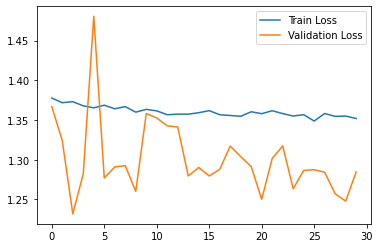

In [263]:
plt.plot(history.history['loss'],label = "Train Loss")
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()
plt.show()

In [272]:
score, acc = model.evaluate(encoded_test_reviews, test_ratings)

439/439 [==============================] - 7s 15ms/step - loss: 1.2856 - accuracy: 0.4780


In [265]:
train_ratings.sum(axis = 0 )

array([ 2767.,  3871.,  6432., 15391., 27695.])

In [273]:
prob_test = np.round(model.predict(encoded_test_reviews))
prob_test = pd.DataFrame(data = prob_test, columns = ['1', '2', '3','4','5'])
prob_test = prob_test.idxmax(axis = 1)

test_ratings_df = pd.DataFrame(data = test_ratings, columns = ['1', '2', '3','4','5'])
y_test_label = test_ratings_df.idxmax(axis = 1)

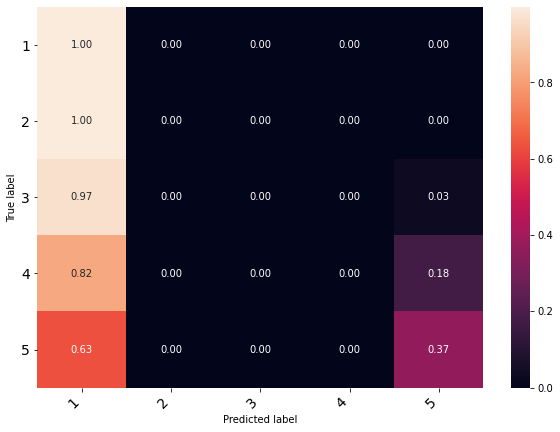

In [274]:

# Calculate confusion matrix
confusion_matrix_dnn = confusion_matrix(y_true = y_test_label, 
                    y_pred = prob_test)

# Turn matrix to percentages
confusion_matrix_dnn = confusion_matrix_dnn.astype('float') / confusion_matrix_dnn.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_dnn, index=['1', '2', '3','4','5'],
         columns=['1', '2', '3','4','5'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

In [275]:
accuracy_score(y_test_label,prob_test)*100

23.178289051926775

In [276]:
prob_train = np.round(model.predict(encoded_train_reviews))
prob_train = pd.DataFrame(data = prob_train, columns = ['1', '2', '3','4','5'])
prob_train = prob_train.idxmax(axis = 1)

train_ratings_df = pd.DataFrame(data = train_ratings, columns = ['1', '2', '3','4','5'])
y_train_label = train_ratings_df.idxmax(axis = 1)

In [270]:
accuracy_score(y_train_label,prob_train)*100

23.397321746563147

#Categories

In [253]:
# Generate the input
cat_input = Input(shape=(4, ))

# Generate the embedding
embed_input_cat = Embedding(input_dim = 4 ,        # Input size
                                output_dim = 30,           # Embedding dimensions
                                input_length=4,            # Variables.
                                trainable=True)(cat_input) # Allow weight training.

# Flatten the embedding to make it a proper layer.
embed_input_cat = Flatten()(embed_input_cat)

In [254]:
x = concatenate([embed_input_cat, out])
# Dense layers
x = Dense(128, activation= 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(0.2)(x)

# Output layer
out_combined = Dense(ratings.shape[1], activation = 'softmax')(x)

In [255]:
Multi_Model = Model(inputs = [embed_in, cat_input], outputs = out_combined)

# adam = Adam(clipnorm=.1)
Multi_Model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [256]:
Multi_Model.summary()

Model: "functional_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 14, 500)]    0                                            
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 13, 128)      128128      input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 12, 128)      192128      input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 11, 128)      256128      input_14[0][0]                   
_______________________________________________________________________________________

In [239]:
type(encoded_train_reviews)

numpy.ndarray

In [257]:
cat_features = review_df[['open_days','Breakfast','Lunch','Dinner']].to_numpy()

In [258]:
cat_train = np.array(cat_features[:train_len])
cat_test = np.array(cat_features[train_len:])

In [259]:
multi_train = np.concatenate([cat_train,encoded_train_reviews], axis = 1)
multi_test = np.concatenate([cat_test,encoded_test_reviews], axis = 1)
                       

In [260]:
multi_train[:, 4:].shape

(56156, 14)

In [261]:
Multi_Model.fit([multi_train[:, 4:],multi_train[:, 0:4]], y = train_ratings,
                validation_split = 0.2, class_weight = class_weight,
                epochs = 10, batch_size = 120)

Epoch 1/10


ValueError: ignored